In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch.nn as nn
import torchvision
import torch.optim as optim


import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import top_k_accuracy_score
from main import Xception, print_test_details, train_transform, test_transform
from main import print_test_details, ResNet, BasicBlock, BottleNeck, train_transform, test_transform #custom function in main.py
import cv2


import json, os


In [3]:
# HYPERPARAMETERS

train_size = 0.8
test_size=0.2
cuda = 'cuda'
cpu = 'cpu' 
device = cuda if torch.cuda.is_available() else cpu


In [4]:

class myDataset(torch.utils.data.Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x, y = self.data[index]
        if self.transform:
            x = self.transform(x)
        return x, y
   


In [86]:

full_dataset = torchvision.datasets.ImageFolder(
    root='./dataset',
    transform=None
)

train, test = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(0))


test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


# train_dataset = myDataset(train, transform=train_transform)
test_dataset = myDataset(test, transform=test_transform)

# batch_size=64

# train_loader = torch.utils.data.DataLoader(
#     dataset=train_dataset,
#     batch_size=batch_size,
#     shuffle=True, 
# )




test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False   
)   

In [87]:

resnet = ResNet(
    block=BottleNeck,
    layers=[2, 2, 2, 2]
)

resnet.load_state_dict(torch.load("resnet28_selfimplementation_kaggle.pth"))
resnet.to(device)
resnet.eval()


xception = Xception(5)
xception.load_state_dict(torch.load("xception_middle5_5.9M.pth"))
xception.to(device)
xception.eval()

print()



### Function for generating the heatmap

In [88]:
def process_image(path, output_size=224, random_crop:bool=False, normalize=True):

    img = cv2.imread(path, cv2.IMREAD_COLOR)


    img = transforms.ToTensor()(img)

    if random_crop:
        img = transforms.Resize(output_size+32)(img)
        img = transforms.RandomCrop(output_size)
    else:
        img = transforms.Resize((output_size, output_size))(img)

    
    if normalize:
        img = transforms.Normalize([0.5]*3, [0.5]*3)(img)

    return img.to(device)
    
def get_conv_layer(model, conv_layer_name):
    for name, layer in model.named_modules():
        if name == conv_layer_name:
            return layer
    raise ValueError(f"Layer '{conv_layer_name}' not found in the model.")


In [152]:
def compute_gradcam(model, image_tensor:torch.Tensor, class_index, layer_name):

    assert image_tensor.shape[0] == 3 or image_tensor.shape[1]==3, "Number of channels must 3, if either batched or unbatched input"
    
    conv_layer:nn.Module = get_conv_layer(model, layer_name)

    activations:torch.Tensor = None
    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    hook = conv_layer.register_forward_hook(forward_hook)

    if image_tensor.ndim == 3:
        image_tensor = torch.unsqueeze(image_tensor, 0)

    image_tensor.requires_grad_(True)
    predictions = model(image_tensor)
    class_loss = predictions[:, class_index]

    model.zero_grad()
    model.eval()
    class_loss.backward()

    grads = image_tensor.grad.cpu().numpy()
    pooled_grads = np.mean(grads, axis=(0, 2, 3))

    hook.remove()

    activations = activations.detach().cpu().numpy()[0]
    for i in range(pooled_grads.shape[0]):
        activations[i, ...] *= pooled_grads[i]
    
    heatmap = np.mean(activations, axis=0)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def overlay_heatmap(img_path, heatmap, alpha=0.7):

    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)
    return superimposed_img


#### Example of how to get heatmap from an image path

In [166]:
bat_path = "./dataset/213.teddy-bear/213_0008.jpg"

img_tensor = process_image(bat_path)

class_index=7

heatmap = compute_gradcam(xception, img_tensor, class_index, "exitblock1_conv2" )
output_img = overlay_heatmap(bat_path, heatmap)
cv2.imwrite("heatmap.jpg", output_img) 

True

In [154]:
correctly_classified_xception = correctly_classified_resnet = ['./dataset\\250.zebra\\250_0029.jpg',
 './dataset\\230.trilobite-101\\230_0011.jpg',
 './dataset\\087.goldfish\\087_0058.jpg',
 ]


incorrectly_classified_resnet = incorrectly_classified_xception = ['./dataset\\251.airplanes-101\\251_0399.jpg',
 './dataset\\193.soccer-ball\\193_0049.jpg',
 './dataset\\145.motorbikes-101\\145_0094.jpg']


correctly_classified_resnet_images = []
incorrectly_classified_resnet_images = []
correctly_classified_xception_images = []
incorrectly_classified_xception_images = []


for i in correctly_classified_xception:
    img_tensor = process_image(i, 299)
    class_label = int(i.split('\\')[-1].split('_')[0])-1
    heatmap = compute_gradcam(xception, img_tensor, class_label, "exitblock1_conv2" )
    output_img = overlay_heatmap(i, heatmap)
    correctly_classified_xception_images.append(output_img)


for i in incorrectly_classified_xception:
    img_tensor = process_image(i, 299)
    class_label = int(i.split('\\')[-1].split('_')[0])-1
    heatmap = compute_gradcam(xception, img_tensor, class_label, "exitblock1_conv2" )
    output_img = overlay_heatmap(i, heatmap)
    incorrectly_classified_xception_images.append(output_img)



for i in correctly_classified_resnet:
    img_tensor = process_image(i)
    class_label = int(i.split('\\')[-1].split('_')[0])-1
    heatmap = compute_gradcam(resnet, img_tensor, class_label, "layer4" )
    output_img = overlay_heatmap(i, heatmap)
    correctly_classified_resnet_images.append(output_img)


for i in incorrectly_classified_resnet:
    img_tensor = process_image(i)
    class_label = int(i.split('\\')[-1].split('_')[0])-1
    heatmap = compute_gradcam(resnet, img_tensor, class_label, "layer4" )
    output_img = overlay_heatmap(i, heatmap)
    incorrectly_classified_resnet_images.append(output_img)



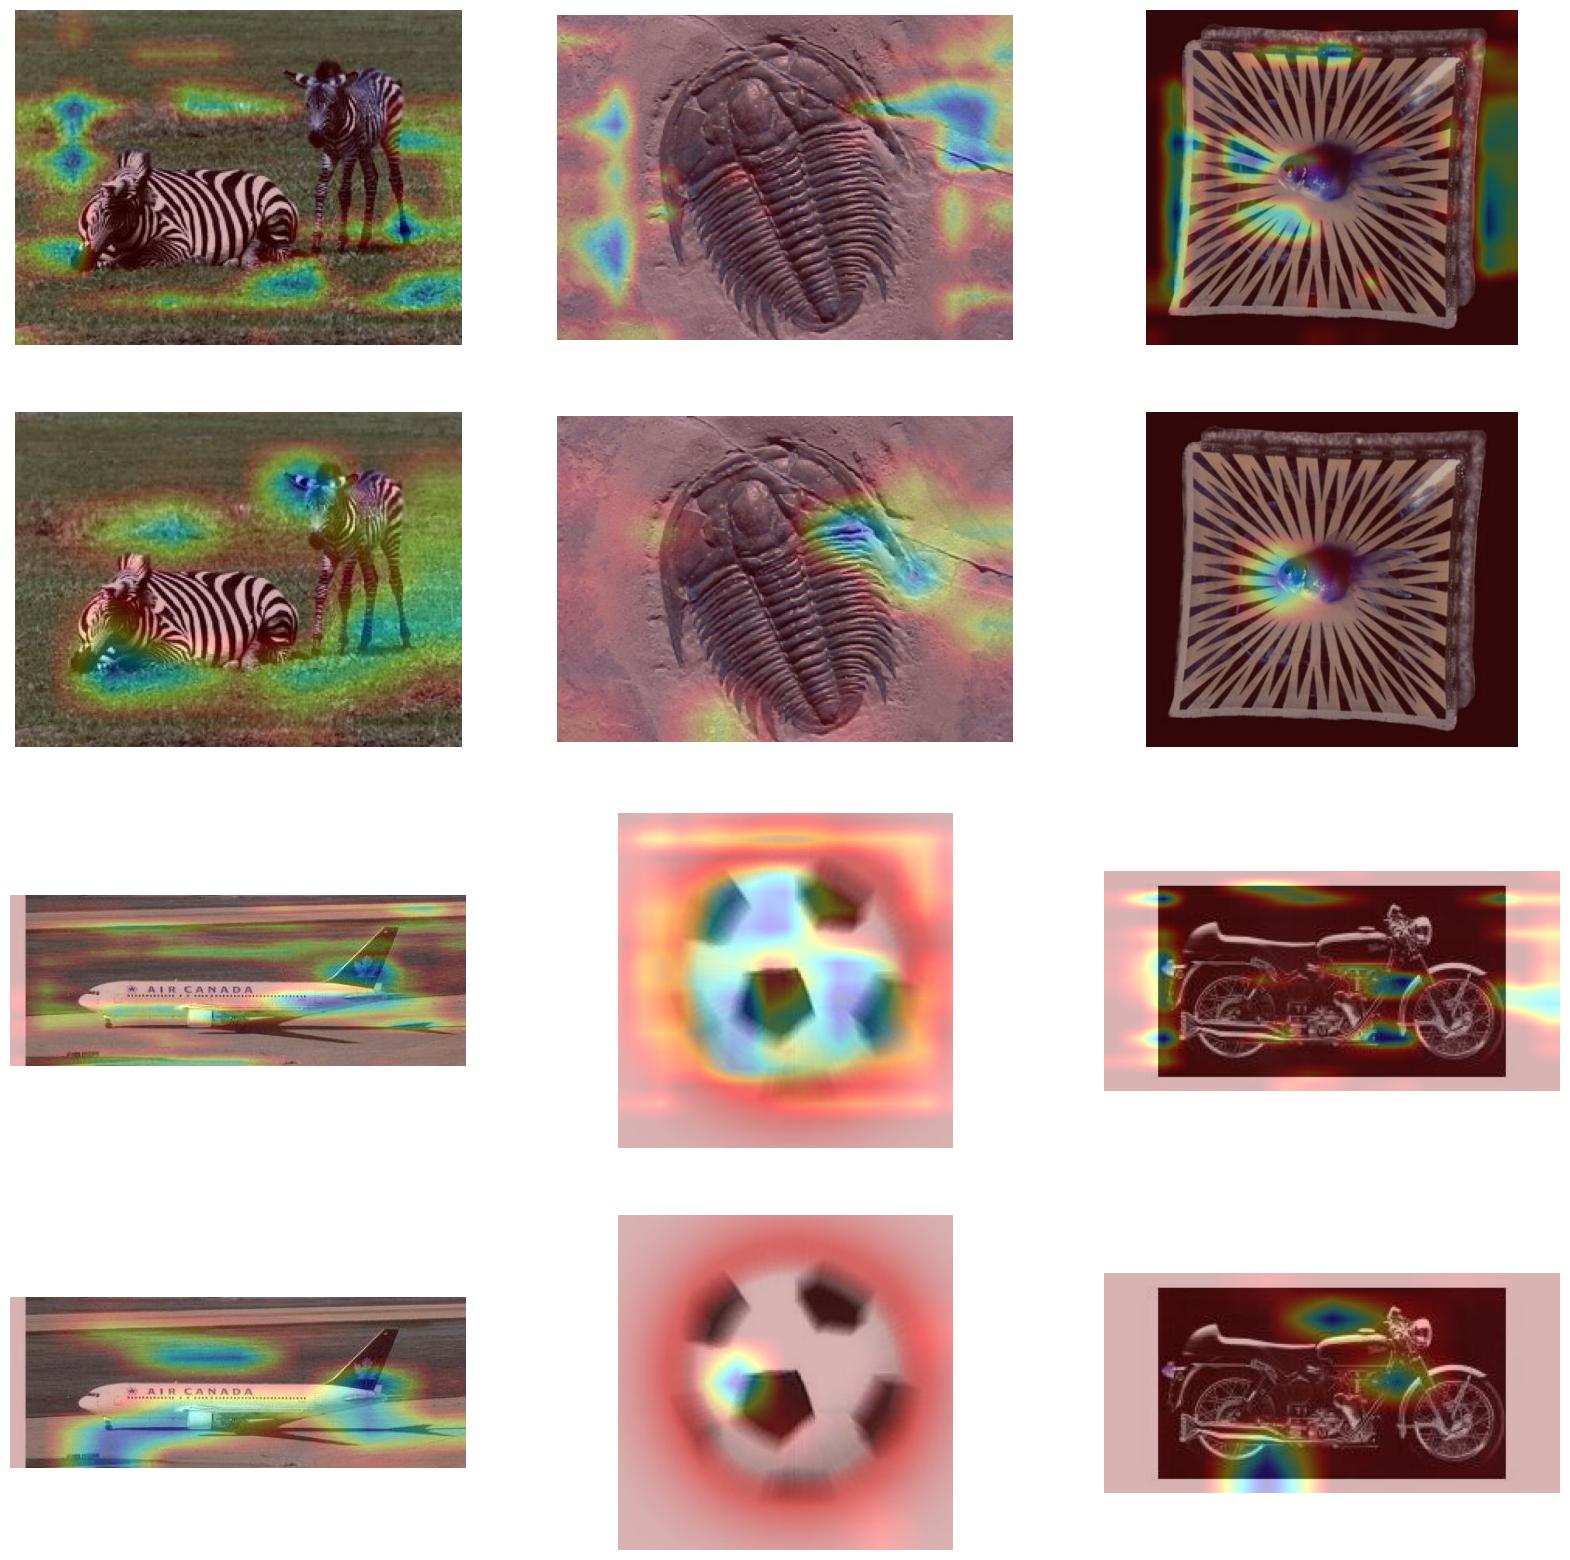

In [164]:
figure, ax = plt.subplots(4, 3, figsize=(20, 20))



for i, image in enumerate(correctly_classified_xception_images):
    ax[0, i].imshow(image)
for i, image in enumerate(correctly_classified_resnet_images):
    ax[1, i].imshow(image)
for i, image in enumerate(incorrectly_classified_xception_images):
    ax[2, i].imshow(image)
for i, image in enumerate(incorrectly_classified_resnet_images):
    ax[3, i].imshow(image)

for a in ax.flat:
    a.axis('off')

In [ ]:
images = []
for root, _, files in os.walk("./dataset"):
    for file in files:
        if file.endswith(".jpg"):
            images.append(os.path.join(root, file))


images = np.array(images)
np.random.seed(0)
np.random.shuffle(images)

correctly_classified_resnet = []
incorrectly_classified_resnet = []

correctly_classified_xception = []
incorrectly_classified_xception = []


for image_path in images:

    class_label = int(images[0].split('\\')[-1].split('_')[0])-1

    image_tensor_resnet = torch.unsqueeze(process_image(image_path), 0)

    any = False
    output = resnet(image_tensor_resnet)

    if (torch.argmax(output, -1).item()==class_label):# and len(correctly_classified_resnet) < 5:
        any = True
        correctly_classified_resnet.append(image_path)

    if (torch.argmax(output, -1).item()!=class_label):# and len(incorrectly_classified_resnet) < 5:
        any = True
        incorrectly_classified_resnet.append(image_path)
    
    image_tensor_xception = process_image(image_path, 299)

    if (torch.argmax(output, -1).item()==class_label):# and len(correctly_classified_xception) < 5:
        any = True
        correctly_classified_xception.append(image_path)

    if (torch.argmax(output, -1).item()!=class_label):# and len(incorrectly_classified_xception) < 5:
        any = True
        incorrectly_classified_xception.append(image_path)
    
    



    

In [ ]:


correctly_classified_resnet = []
incorrectly_classified_resnet = []

correctly_classified_xception = []
incorrectly_classified_xception = []

i= 0

for image_path in images:

    i+= 1

    class_label = int(images[0].split('\\')[-1].split('_')[0])-1

    image_tensor_resnet = torch.unsqueeze(process_image(image_path), 0)

    any = False
    output = resnet(image_tensor_resnet)

    if (torch.argmax(output, -1).item()==class_label) and len(correctly_classified_resnet) < 5:
        any = True
        correctly_classified_resnet.append(image_path)

    if (torch.argmax(output, -1).item()!=class_label) and len(incorrectly_classified_resnet) < 5:
        any = True
        incorrectly_classified_resnet.append(image_path)
    
    image_tensor_xception = torch.unsqueeze(process_image(image_path, 299), 0)
    output = xception(image_tensor_xception)

    if (torch.argmax(output, -1).item()==class_label) and len(correctly_classified_xception) < 5:
        any = True
        correctly_classified_xception.append(image_path)

    if (torch.argmax(output, -1).item()!=class_label) and len(incorrectly_classified_xception) < 5:
        any = True
        incorrectly_classified_xception.append(image_path)
    


    if min(correctly_classified_resnet,
incorrectly_classified_resnet,
correctly_classified_xception,
incorrectly_classified_xception, key=lambda x: len(x)) == 5:
        break

    if (i%100==0):
        print(i)
        
    